In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv1D, MaxPooling1D, GlobalAveragePooling1D, BatchNormalization
from keras.losses import categorical_crossentropy, binary_crossentropy, mse
from sklearn.model_selection import GroupShuffleSplit
from sklearn.utils import class_weight
from sklearn.metrics import roc_curve, roc_auc_score, auc, accuracy_score
import sklearn
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import regularizers

Using TensorFlow backend.


### Training Set

In [24]:
X, X_test = np.load('datasets/X.npy'), np.load('datasets/X_test.npy')
Y, Y_test = np.load('datasets/Y.npy'), np.load('datasets/Y_test.npy')
groups, groups_test = np.load('datasets/groups.npy'), np.load('datasets/groups_test.npy')
print("number of training samples:", len(X))
print("number of testing samples:", len(X_test))

number of training samples: 34320
number of testing samples: 2204


#### Plot input

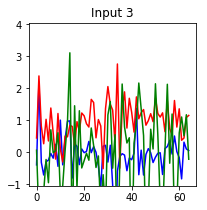

In [26]:
def plot_input(input_nr):
    fig = plt.figure(figsize=(3, 3))
    plt.plot(X[input_nr-1,0,:], color='b')
    plt.plot(X[input_nr-1,1,:], color='r')
    plt.plot(X[input_nr-1,2,:], color='g')
    plt.ylim([-1.05, 4.05])
    plt.title("Input %d" %input_nr)
    plt.show()

plot_input(3)

#### Baseline Accuracy

In [61]:
Baseline_accuracy = Y[Y[:,1]==0].sum()/len(Y)
print("Baseline accuracy:", Baseline_accuracy)

Baseline accuracy: 0.9727272727272728


#### Choose window size

In [28]:
window_size=65
X, X_test = X[:,:,0:window_size], X_test[:,:,0:window_size]

#### Split training set

In [29]:
cv = GroupShuffleSplit(n_splits=1, test_size=0.5)
train, valid = next(cv.split(X, Y, groups))

In [30]:
datasets = ["Training", "Validation", "Testing"]
inputs = [X[train], X[valid], X_test]
targets = [Y[train], Y[valid], Y_test]
groups_all = [groups[train], groups[valid], groups_test]

In [31]:
scuotimenti = [184, 185, 186, 191, 1211, 1212, 1213, 1214, 1215, 1216, 1219, 1220, 1506]
pallonate = [139, 140, 1507, 1508, 1510, 1511, 1513, 1514, 2139, 2140, 4139, 6139, 8139, 10139] 
for i in range(len(inputs)):
    print(datasets[i])
    print("nr scuotimenti:", np.isin(np.unique(groups_all[i]), scuotimenti).sum())
    print("nr pallonate:", np.isin(np.unique(groups_all[i]), pallonate).sum(), "\n")

Training
nr scuotimenti: 6
nr pallonate: 2 

Validation
nr scuotimenti: 5
nr pallonate: 1 

Testing
nr scuotimenti: 2
nr pallonate: 2 



### Train Neural Network

#### Create networks

In [69]:
def double_dense():
    model = Sequential()
    model.add(Dense(64, input_shape=(window_size*3,)))
    model.add(Activation('relu'))
    model.add(Dense(2)) 
    model.add(Activation('softmax'))
    model.compile(loss=categorical_crossentropy, optimizer='Adam', metrics=['accuracy'])
    return model

def dropout_model():
    model = Sequential()
    model.add(Dense(128, kernel_regularizer=regularizers.l2(0.01), activity_regularizer=regularizers.l1(0.01), input_shape=(window_size*3,)))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(2)) 
    model.add(Activation('softmax'))
    model.compile(loss=categorical_crossentropy, optimizer='Adam', metrics=['accuracy'])
    return model

def BN_model1():
    model = Sequential()
    model.add(Dense(64, input_shape=(window_size*3,)))
    model.add(BatchNormalization(momentum=0.99, epsilon=0.001))
    model.add(Activation('relu'))
    model.add(Dense(2)) 
    model.add(BatchNormalization(momentum=0.99, epsilon=0.001))
    model.add(Activation('softmax'))
    model.compile(loss=categorical_crossentropy, optimizer='Adam', metrics=['accuracy'])
    return model

def CNN_model():
    model = Sequential()
    model.add(Conv1D(5, 9, input_shape=(window_size*3, 1)))
    model.add(Activation('relu'))
    model.add(MaxPooling1D(4))
    model.add(Flatten())
    model.add(Dense(8))
    model.add(BatchNormalization(momentum=0.99, epsilon=0.001))
    model.add(Activation('relu'))
    model.add(Dense(2))
    model.add(BatchNormalization(momentum=0.99, epsilon=0.001))
    model.add(Activation('softmax'))
    model.compile(loss=categorical_crossentropy, optimizer='rmsprop', metrics=['accuracy'])
    return model

def CNN_leCun():
    model = Sequential()
    model.add(Conv1D(5, 5, input_shape=(window_size*3, 1)))
    model.add(Activation('relu'))
    model.add(MaxPooling1D(2))
    model.add(Conv1D(5, 5))
    model.add(Activation('relu'))
    model.add(MaxPooling1D(2))
    model.add(Conv1D(20, 5, input_shape=(window_size*3, 1)))
    model.add(Activation('relu'))
    model.add(MaxPooling1D(4))
    model.add(Flatten())
    model.add(Dense(24))
    model.add(Activation('relu'))
    model.add(Dense(2))
    model.add(Activation('softmax'))
    model.compile(loss=categorical_crossentropy, optimizer='rmsprop', metrics=['accuracy'])
    return model

def CNN_model3():
    model = Sequential()
    model.add(Conv1D(10, 10, input_shape=(window_size*3, 1)))
    model.add(BatchNormalization(momentum=0.99, epsilon=0.001))
    model.add(Activation('relu'))
    model.add(Conv1D(10, 10, input_shape=(window_size*3, 1)))
    model.add(BatchNormalization(momentum=0.99, epsilon=0.001))
    model.add(Activation('relu'))
    model.add(MaxPooling1D(3))
    model.add(Conv1D(10, 10, input_shape=(window_size*3, 1)))
    model.add(BatchNormalization(momentum=0.99, epsilon=0.001))
    model.add(Activation('relu'))
    model.add(Conv1D(10, 10, input_shape=(window_size*3, 1)))
    model.add(BatchNormalization(momentum=0.99, epsilon=0.001))
    model.add(Activation('relu'))
    model.add(GlobalAveragePooling1D())
    model.add(Dropout(0.5))
    model.add(Dense(2))
    model.add(BatchNormalization(momentum=0.99, epsilon=0.001))
    model.add(Activation('softmax'))    
    model.compile(loss=categorical_crossentropy, optimizer='rmsprop', metrics=['accuracy'])
    return model
#    print(model_m.summary())

model1 = double_dense()
model2 = dropout_model()
model3 = BN_model1()
model4 = CNN_model()
model_new = CNN_leCun()
model6 = CNN_model3()

#### Choose model

In [ ]:
model = model5
#model = keras.models.load_model("models/super_best.model")

#### Train Model On Training Set Only

In [35]:
# Useful function to train models
def shape(X):
    return tuple([len(X)] + list(model_new.input_shape)[1:])

In [70]:
epochs = 50
cw = class_weight.compute_class_weight('balanced', np.unique(np.argmax(Y[train], axis=1)), np.argmax(Y[train], axis=1))
callback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, restore_best_weights=True, patience=1, verbose=0, mode='auto')

history = model_new.fit(
    X[train].reshape(shape(X[train])), 
    Y[train], 
    callbacks=[callback], 
    epochs=epochs, 
    batch_size=32, 
    validation_data = [X[valid].reshape(shape(X[valid])), 
    Y[valid]], 
    class_weight=cw,
    verbose=1)

Train on 11996 samples, validate on 22324 samples
Epoch 1/50
11996/11996 [==============================] - 23s 2ms/step - loss: 0.1474 - acc: 0.9551 - val_loss: 0.0339 - val_acc: 0.9851
Epoch 2/50
11996/11996 [==============================] - 21s 2ms/step - loss: 0.0723 - acc: 0.9744 - val_loss: 0.0331 - val_acc: 0.9885
Epoch 3/50
11996/11996 [==============================] - 21s 2ms/step - loss: 0.0392 - acc: 0.9864 - val_loss: 0.0090 - val_acc: 0.9962
Epoch 4/50
11996/11996 [==============================] - 21s 2ms/step - loss: 0.0254 - acc: 0.9914 - val_loss: 0.0312 - val_acc: 0.9917


## Evaluate Model

#### Compute Accuracy

In [37]:
def accuracy(X, Y):
    accuracy = model.evaluate(X.reshape(shape(X)), Y)[1]
    print ("Accuracy:", accuracy)

for i in range(len(inputs)):
    accuracy(inputs[i], targets[i])

11996/11996 [==============================] - 5s 394us/step
Accuracy: 0.988162720906969
22324/22324 [==============================] - 9s 398us/step
Accuracy: 0.9961924386310697
2204/2204 [==============================] - 1s 344us/step
Accuracy: 0.9650635208711433


#### Compute Confusion matrix

In [38]:
def conf_mat(inputs, targets):
    X = np.argmax(model.predict(inputs.reshape(shape(inputs))), axis=1)
    Y = np.argmax(targets, axis=1)
    print ("Confusion matrix:\n", sklearn.metrics.confusion_matrix(Y, X))

for i in range(len(inputs)):
    conf_mat(inputs[i], targets[i])

Confusion matrix:
 [[11324   100]
 [   42   530]]
Confusion matrix:
 [[21960     0]
 [   85   279]]
Confusion matrix:
 [[1684    0]
 [  77  443]]


#### Compute ROC

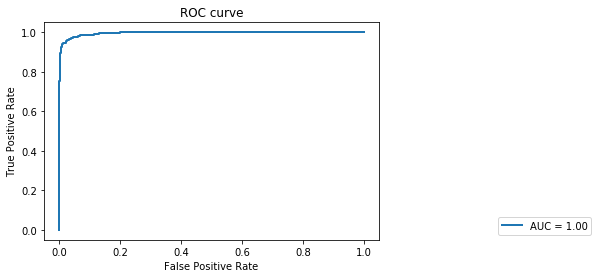

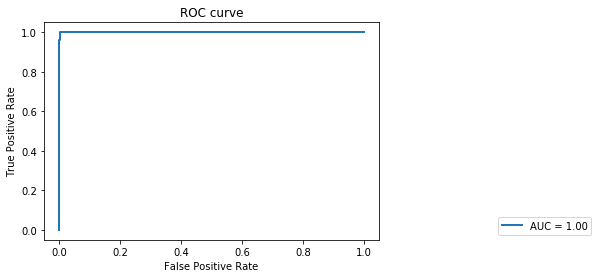

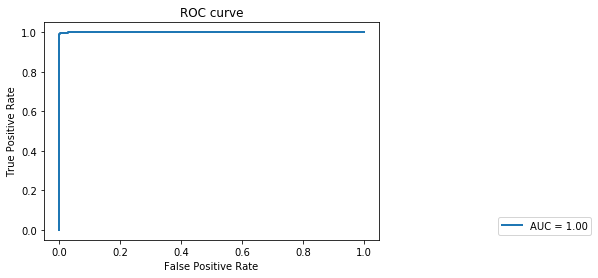

In [45]:
def compute_ROC(X, Y):
    probas = model.predict(X.reshape(shape(X)))[:, 1]
    fpr, tpr, thresholds = roc_curve(np.argmax(Y, axis=1), probas)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, alpha=1, label='AUC = %0.2f' % (roc_auc))
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve') 
    plt.legend(loc="lower right", bbox_to_anchor=(1.65, 0))
    plt.show()

for i in range(len(inputs)):
    compute_ROC(inputs[i], targets[i])

#### ROC on Events

(26,) (26,)


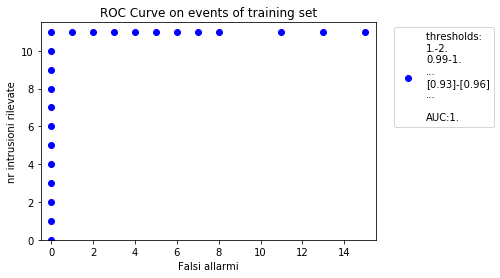

(27,) (27,)


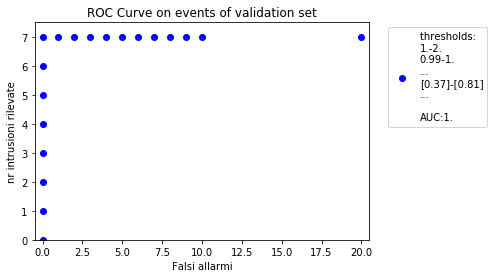

(19,) (19,)


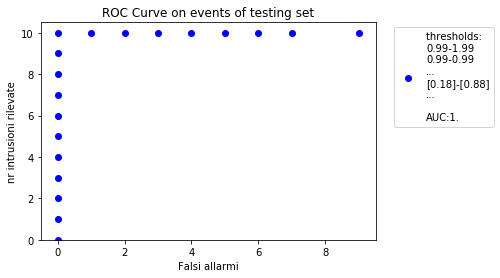

In [39]:
from sklearn.utils.fixes import signature

def ROC_events(X1, Y1, i):
    fpr, tpr, thresholds = roc_curve(Y1, X1, drop_intermediate=False)
    A1 = np.where(fpr==0)
    A2 = np.where(tpr==1)
    A3 = np.intersect1d(A1, A2)
    thres = np.round(thresholds, decimals=2)
    roc_auc = auc(fpr, tpr)
    label = "thresholds: \n"
    for j in range(2):
        label = label + np.array2string(thres[j+1]) + "-" + np.array2string(thres[j]) + "\n"
    label = label + "...\n"
    label = label + np.array2string(thres[A3+1]) + "-" + np.array2string(thres[A3]) + "\n"
    label = label + "...\n"
    label = label + "\nAUC:" + np.array2string(roc_auc)
    step_kwargs = ({'step': 'post'} if 'step' in signature(plt.fill_between).parameters else {})
    plt.scatter(fpr*(Y1[:]==0).sum(), tpr*(Y1[:]==1).sum(), color='b', label=label)
    plt.xlabel('Falsi allarmi')
    plt.ylabel('nr intrusioni rilevate')
    plt.ylim([0.0, (Y1[:]==1).sum()+0.5])
    plt.xlim([-0.5, (Y1[:]==0).sum()+0.5])
    plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
    plt.title('ROC Curve on events of %s set' %datasets[i].lower())
    plt.show()

for i in range(3):
    nr_intrusions = len(np.unique(groups_all[i][targets[i][:,1]==1]))
    nr_non_intrusions = len(np.unique(groups_all[i][targets[i][:,1]==0]))
    Yev = np.concatenate((np.ones(nr_intrusions), np.zeros(nr_non_intrusions)))
    Xev = np.zeros(len(Yev))    
    for w, j in enumerate (np.concatenate((np.unique(groups_all[i][targets[i][:,1]==1]), np.unique(groups_all[i][targets[i][:,1]==0])))):
        Xev[w] = np.round(np.max(model.predict(inputs[i][groups_all[i]==j].reshape(shape(inputs[i][groups_all[i]==j])))[:,1]), decimals=4)
    ROC_events(Xev, Yev, i)

## Final Training

In [638]:
cw = class_weight.compute_class_weight('balanced', np.unique(np.argmax(Y, axis=1)),np.argmax(Y, axis=1))
early = EarlyStopping(monitor='loss', min_delta=0, patience=10, verbose=1, mode='auto', baseline=None)
model.fit(X.reshape(shape(X)), Y, epochs=100, callbacks = [early], class_weight=cw, verbose=1)

Epoch 1/100
34640/34640 [==============================] - 10s 286us/step - loss: 0.0801 - acc: 0.9747
Epoch 2/100
34640/34640 [==============================] - 10s 288us/step - loss: 0.0621 - acc: 0.9765
Epoch 3/100
34640/34640 [==============================] - 9s 264us/step - loss: 0.0543 - acc: 0.9793
Epoch 4/100
34640/34640 [==============================] - 9s 257us/step - loss: 0.0523 - acc: 0.9798
Epoch 5/100
34640/34640 [==============================] - 9s 259us/step - loss: 0.0492 - acc: 0.9812
Epoch 6/100
34640/34640 [==============================] - 9s 258us/step - loss: 0.0473 - acc: 0.9818
Epoch 7/100
34640/34640 [==============================] - 10s 276us/step - loss: 0.0437 - acc: 0.9816
Epoch 8/100
34640/34640 [==============================] - 9s 271us/step - loss: 0.0440 - acc: 0.9828
Epoch 9/100
34640/34640 [==============================] - 9s 264us/step - loss: 0.0429 - acc: 0.9825
Epoch 10/100
34640/34640 [==============================] - 9s 258us/step - los

In [62]:
model.save('models/super_best3.model', model)

KeyError: 'Cannot set attribute. Group with name "keras_version" exists.'

## Model Analysis Room

#### Predictions of intrusions/non intrusions on training, validation and test set 

In [57]:
dataset_nr = 2  
target = 0      # 0 = non intrusions; 1 = intrusions
b = [0]

def print_predictions(dataset_nr, target):
    for j in np.unique(groups_all[dataset_nr][targets[dataset_nr][:,1]==target]):
        X = inputs[dataset_nr][groups_all[dataset_nr]==j]
        a = np.round(model.predict(X.reshape(shape(X)))[:,1], 2)
        print(j, np.max(a))
print_predictions(dataset_nr, target)
print(b)

68 0.0
69 0.0
193 0.0
1186 0.0
1217 0.0
1220 0.12
1506 0.02
1511 0.02
1513 0.18
[0]


#### Inspect weights

In [59]:
W1 = model.layers[0].get_weights()
for i in range(5):
    print(np.round(W1[0][i],1))

[[ 0.5 -0.2  0.3 -0.4  0.5]]
[[ 0.   0.3 -0.3  0.3  0.1]]
[[-0.3 -0.3  0.3  0.5 -0.2]]
[[ 0.  -0.4  0.4 -0.5  0.3]]
[[-0.6  0.2  0.3  0.4  0. ]]


### Objectives

<input type="checkbox" checked> Should detect 19/20 intrusions on testing set OK <br>
<input type="checkbox"> 1 false alarm per year